In [269]:
import urllib2 
from __future__ import print_function
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt 
import seaborn as sns
% matplotlib inline

Your task is to develop a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell.

Even though this seems like a fairly straightforward task, there are so many ways you can explore, visualize, engineer your features, and tell a story with this data! Being able to clearly communicate your thought process is one of the most important parts of a data challenge. Some important questions to think about are: how can you best explore the data? Why did you select your particular model? How did you validate your model?

Please code and annotate your analysis in an Jupyter notebook.  If you are insistent on using R, there are ways to do that in Jupyter as well. No one has demos today so please complete everything this afternoon and then upload your final product into Dropbox (Data Challenges/Week 5).

The dataset consists of 699 cells for which you have the following features:

1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)

In [172]:
labels = ['thickness', 'size', 'shape', 'adhesion', 'epithelial', 'nuclei', 'chromatin', 'nucleoli', 'mitoses']

# Helper functions

In [173]:
def plot_coeffs(coeffs, labels):
    """
    coeffs: vector of floats
    labels: array of strings
    """
    fig= plt.figure(figsize=(10,10))
    sns.barplot(np.array(labels), coeffs.flatten(), palette="Set3")

# Load data from url

In [297]:
f = urllib2.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')
n_samples = 699
n_features = 11
data = np.zeros((n_samples, n_features), dtype='f4')
for j,line in enumerate(f):
    for i,element in enumerate(line.split(',')):
        try:
            data[j,i]=float(element)
        except:
            data[j,i]=np.nan

# Get rid of NaNs

In [307]:
np.where(np.isnan(data))
data = np.delete(data,6,axis=1)
labels = np.delete(np.array(labels),6)


# Split into covariates and target values

In [308]:
X = data[:,1:-1] # skip the indexes and last row
y = ((data[:,-1]==4.)*1).astype('int') # last row are the target values

Are the classes imbalanced in the data? Yes, this will condition how we will do the splits for the validation.

In [293]:
np.bincount(y)

array([458, 241])

# Centering and standardizing the features

 Center and standardize the features for learning  

In [222]:
X = (X-X.mean(axis=0,keepdims=True))/X.std(axis=0,keepdims=True)

# Split between train and test for validation 

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)

# Logistic classifier

First we start by fitting the vanilla Logistic classifier from scikit-learn

In [251]:
clf = LogisticRegression()

In [252]:
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [253]:
print(classification_report(y_test,clf.predict(X_test), target_names=['benign','malignant']))

             precision    recall  f1-score   support

     benign       0.98      0.99      0.98        97
  malignant       0.98      0.95      0.96        43

avg / total       0.98      0.98      0.98       140



# Visualization of the model coefficients

Visualizing the coefficients gives us an idea of which features may be most relevant

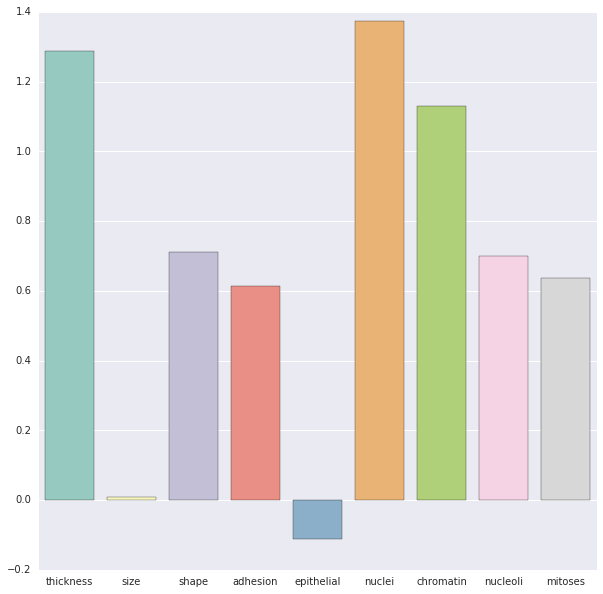

In [254]:
plot_coeffs(clf.coef_,labels)

# L1 regularization

Adding L1 regularization can give us a better idea of which features we can discard to make the model more interpretable and parsimonious

In [244]:
l1_clf = LogisticRegression(penalty='l1',C=.1)

In [245]:
l1_clf.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [246]:
print(classification_report(y_test,l1_clf.predict(X_test), target_names=['benign','malignant']))

             precision    recall  f1-score   support

     benign       0.98      0.99      0.98        97
  malignant       0.98      0.95      0.96        43

avg / total       0.98      0.98      0.98       140



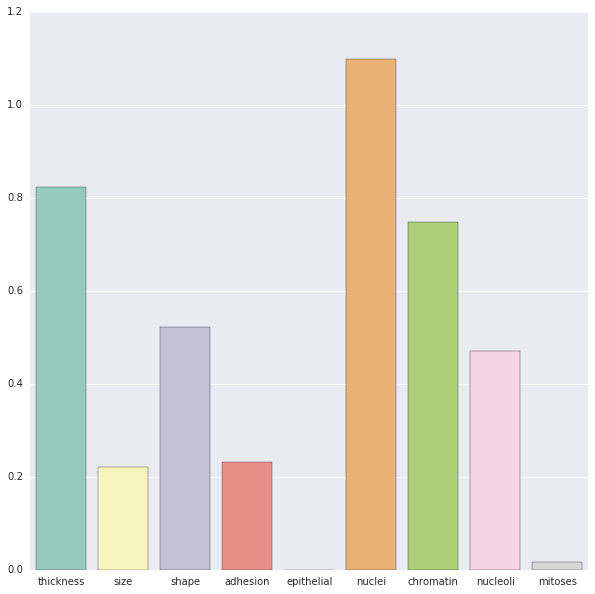

In [247]:
plot_coeffs(l1_clf.coef_,labels)

It seems that without epitheal cell size and mitoses we get pretty good results.

# Hyper-parameter tuning

Now lets try to do it a bit more systematically. We define a range of hyper-parameter C values and we train different models. This will reveal wich model is the most parsimonious and help us discard some mostly uninformative features. We use stratified k-fold crossvalidation to get "confidence intervals" around the scores for each value of C. A stratified will take into account that the classes are imbalanced. 

In [288]:
c_values = np.logspace(-3,3,10)
n_splits = 10 # number of splits for crossvalidation

In [289]:
clfs = []

scores = np.zeros((2,n_splits,3,len(c_values)))

np.random.seed(1234)

kf = StratifiedKFold(n_splits=n_splits)

for j, (train, test) in enumerate(kf.split(X,y)):

    for i, c in enumerate(c_values):
    
        X_train = X[train]
        y_train = y[train]
        
        clfs.append(LogisticRegression(penalty='l1',C=c))
        clfs[i].fit(X_train,y_train)
        
        X_test = X[test]
        y_test = y[test]

        pred_test = clfs[i].predict(X_test)
        pred_train = clfs[i].predict(X_train)

        scores[0,j,0,i] = f1_score(y_train,pred_train)
        scores[1,j,0,i] = f1_score(y_test,pred_test)

        scores[0,j,1,i] = precision_score(y_train,pred_train)
        scores[1,j,1,i] = precision_score(y_test,pred_test)  

        scores[0,j,2,i] = recall_score(y_train,pred_train)
        scores[1,j,2,i] = recall_score(y_test,pred_test)
    

# Visualizing the  scores

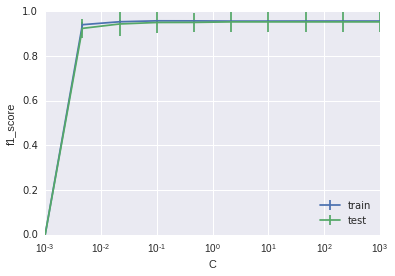

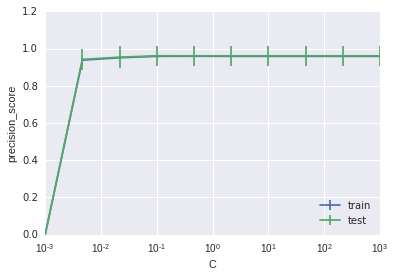

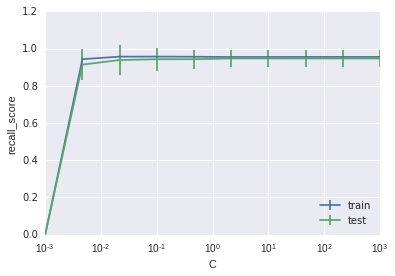

In [291]:
for i,label in enumerate(['f1_score', 'precision_score', 'recall_score']):
    plt.figure()
    plt.errorbar(x=c_values,y=scores[0,:,i].mean(0),yerr=scores[0,:,i].std(0),label='train')
    plt.errorbar(x=c_values,y=scores[1,:,i].mean(0),yerr=scores[1,:,i].std(0),label='test')
    plt.xscale('log')
    plt.ylabel(label)
    plt.xlabel("C")
    plt.legend(frameon=False,loc='lower right')

We chose the second model since it is the most parsimonious one (small C means high regularization) and it has good performance measured by precision and recall.

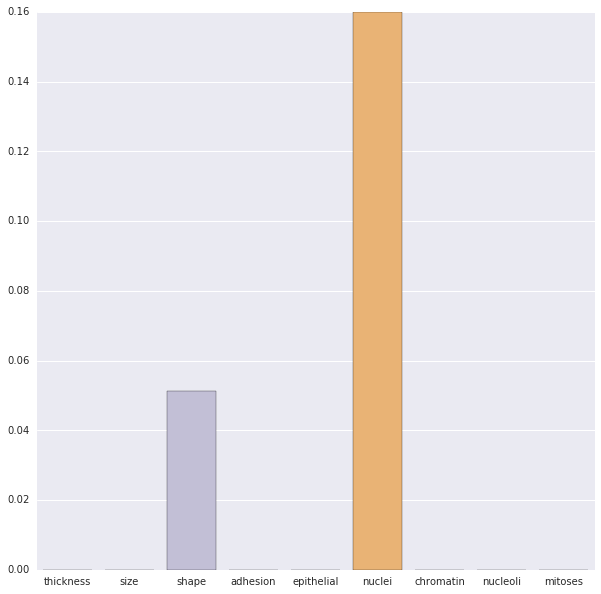

In [294]:
plot_coeffs(clfs[1].coef_,labels)

In [295]:
print(classification_report(y_test,clfs[1].predict(X_test), target_names=['benign','malignant']))

             precision    recall  f1-score   support

     benign       0.92      1.00      0.96        45
  malignant       1.00      0.83      0.91        24

avg / total       0.95      0.94      0.94        69



We can now discard some features